In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
# import seaborn as sns

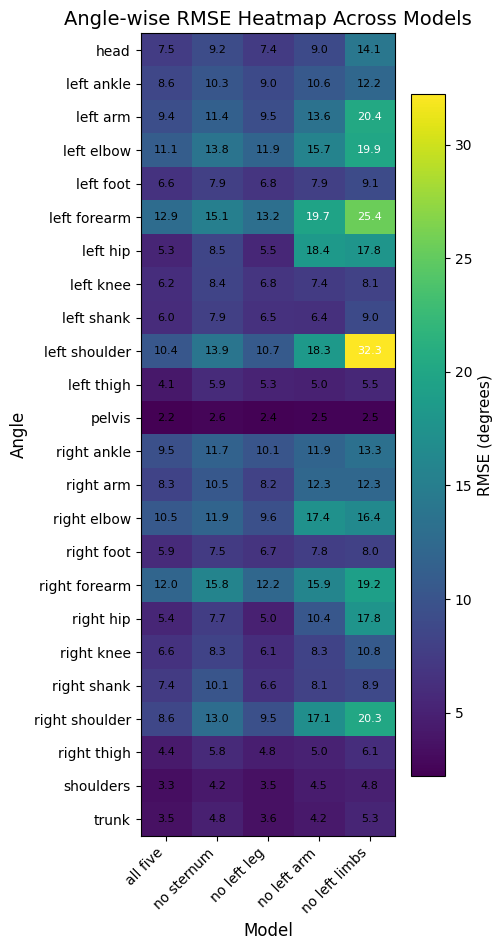

In [ ]:
# === Step 1: CONFIGURATION ===

# Actual run directories
root_dirs = [
    "logs/run_2025-05-05_01-36-19",
    "logs/run_2025-05-05_00-44-55",
    "logs/run_2025-05-05_00-51-26",
    "logs/run_2025-05-05_00-56-05",
    "logs/run_2025-05-06_02-47-19"
]

# Folder name to readable model label
model_name_map = {
    "run_2025-05-05_01-36-19": "all five",
    "run_2025-05-05_00-44-55": "no sternum",
    "run_2025-05-05_00-51-26": "no left leg",
    "run_2025-05-05_00-56-05": "no left arm",
    "run_2025-05-06_02-47-19": "no left limbs"
}

# Desired plot order (left to right)
desired_model_order = [
    "all five",
    "no sternum",
    "no left leg",
    "no left arm",
    "no left limbs"
]

# === Step 2: Find per_joint_errors.csv files ===

import os

def find_target_csvs(directories, target_filename="per_joint_errors.csv"):
    matched_files = []
    for dir_path in directories:
        for root, _, files in os.walk(dir_path):
            if target_filename in files:
                matched_files.append(os.path.join(root, target_filename))
    return matched_files

csv_files = find_target_csvs(root_dirs)

# Warn if any folders are unmapped
used_dirs = {os.path.basename(os.path.dirname(f)) for f in csv_files}
unmapped = used_dirs - set(model_name_map.keys())
if unmapped:
    print("Unmapped directories:", unmapped)

# === Step 3: Load and label each CSV ===

import pandas as pd

def load_per_joint_csv(filepath):
    df = pd.read_csv(filepath, index_col=0)
    df.index.name = 'joint'
    df.reset_index(inplace=True)

    df.columns = [col.strip() for col in df.columns]
    df['joint'] = df['joint'].str.strip()

    df_long = df.melt(id_vars='joint', var_name='temp_model', value_name='rmse')

    folder_name = os.path.basename(os.path.dirname(filepath))
    model_label = model_name_map.get(folder_name, folder_name)
    df_long['model'] = model_label

    return df_long[['joint', 'rmse', 'model']]

# Merge all data
all_dfs = [load_per_joint_csv(f) for f in csv_files]
combined_df = pd.concat(all_dfs, ignore_index=True)

# === Step 4: Pivot to matrix form and reorder columns ===

heatmap_df = combined_df.pivot_table(index='joint', columns='model', values='rmse')
heatmap_df = heatmap_df[desired_model_order]  # enforce model order

# === Step 5: Plot heatmap using Matplotlib only ===

import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(1 * len(desired_model_order), max(8, 0.4 * len(heatmap_df))))  # adaptive size

data = heatmap_df.to_numpy()
joints = heatmap_df.index.tolist()
models = heatmap_df.columns.tolist()

# Plot matrix
im = ax.imshow(data, cmap='viridis', aspect='auto')

# Tick labels
ax.set_xticks(np.arange(len(models)))
ax.set_yticks(np.arange(len(joints)))
ax.set_xticklabels(models, rotation=45, ha='right', fontsize=10)
ax.set_yticklabels(joints, fontsize=10)

# Annotate each cell
for i in range(len(joints)):
    for j in range(len(models)):
        val = data[i, j]
        color = 'white' if val > np.nanmax(data) * 0.6 else 'black'
        ax.text(j, i, f"{val:.1f}", ha='center', va='center', color=color, fontsize=8)

# Title and colorbar
ax.set_title("Angle-wise RMSE Heatmap Across Models", fontsize=14)
ax.set_xlabel("Model", fontsize=12)
ax.set_ylabel("Angle", fontsize=12)

cbar = fig.colorbar(im, ax=ax, shrink=0.85)
cbar.set_label("RMSE (degrees)", fontsize=11)

plt.tight_layout()
plt.show()
